<a href="https://colab.research.google.com/github/haidaraf6/MLCAPSTONE/blob/main/MODEL_CHILI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import zipfile
import tensorflow_datasets as tfds


# Prepare the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab/dataset_rice.zip'

In [ ]:
!unrar x -Y "/content/drive/MyDrive/Colab/Rice Dataset.rar" "/content/dataset/"

In [ ]:
import zipfile

file_dataset = '/content/drive/MyDrive/ModelML/Chili/dataset_chili.zip'
zipdata = zipfile.ZipFile(file_dataset, 'r')
zipdata.extractall('dataset')
zipdata.close()


# Model Build

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, PReLU, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 48, 48, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 46, 46, 256)       295168    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 23, 23, 256)     

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, kernel_size, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_shape = (200, 200, 3)
inputs = Input(shape=input_shape)

x = Conv2D(64, (3, 3), padding='same', strides=2)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 256, stride=2)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
*The settings can be changed later*


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/content/dataset/dataset_chili/Train'
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = '/content/dataset/dataset_chili/Train'
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size=32
)


Found 400 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


In [ ]:
from google.colab import files

model.save('model.h5')
files.download('model.h5')

In [ ]:
model_h5 = '/content/drive/MyDrive/Colab/Model/my_model_rice_new.h5'
model=tf.keras.models.load_model(model_h5)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint("/content/checkpoints",
                           monitor='val_accuracy',
                           verbose=1,
                           save_best_only=True,
                           mode='max')


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      if logs['val_accuracy'] > 0.87:
        if logs['val_loss'] < 0.40:
          self.model.stop_training = True

myCallback = myCallback()

# Train the Model

In [ ]:
history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[myCallback, checkpoint])

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.7300
Epoch 1: val_accuracy did not improve from 0.81250
13/13 [==============================] - 5s 369ms/step - loss: 0.6414 - accuracy: 0.7300 - val_loss: 0.6585 - val_accuracy: 0.7425
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.7250
Epoch 2: val_accuracy did not improve from 0.81250
13/13 [==============================] - 7s 539ms/step - loss: 0.7327 - accuracy: 0.7250 - val_loss: 0.6604 - val_accuracy: 0.7600
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.7275
Epoch 3: val_accuracy did not improve from 0.81250
13/13 [==============================] - 5s 357ms/step - loss: 0.7172 - accuracy: 0.7275 - val_loss: 0.7740 - val_accuracy: 0.7000
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.7510 - accuracy: 0.7175
Epoch 4: val_accuracy did not improve from 0.81250
13/13 [================

13/13 [==============================] - 9s 708ms/step - loss: 0.7057 - accuracy: 0.7100 - val_loss: 0.4729 - val_accuracy: 0.8175
Epoch 9/100
13/13 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7550
Epoch 9: val_accuracy improved from 0.81750 to 0.82000, saving model to /content/checkpoints


13/13 [==============================] - 9s 700ms/step - loss: 0.6236 - accuracy: 0.7550 - val_loss: 0.4438 - val_accuracy: 0.8200
Epoch 10/100
13/13 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7825
Epoch 10: val_accuracy did not improve from 0.82000
13/13 [==============================] - 5s 366ms/step - loss: 0.5237 - accuracy: 0.7825 - val_loss: 0.4469 - val_accuracy: 0.8125
Epoch 11/100
13/13 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.7875
Epoch 11: val_accuracy improved from 0.82000 to 0.86250, saving model to /content/checkpoints


13/13 [==============================] - 9s 702ms/step - loss: 0.5649 - accuracy: 0.7875 - val_loss: 0.3580 - val_accuracy: 0.8625
Epoch 12/100
13/13 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.7775
Epoch 12: val_accuracy did not improve from 0.86250
13/13 [==============================] - 5s 402ms/step - loss: 0.5202 - accuracy: 0.7775 - val_loss: 0.4983 - val_accuracy: 0.8075
Epoch 13/100
13/13 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.7850
Epoch 13: val_accuracy did not improve from 0.86250
13/13 [==============================] - 6s 488ms/step - loss: 0.4886 - accuracy: 0.7850 - val_loss: 0.3736 - val_accuracy: 0.8625
Epoch 14/100
13/13 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.8200
Epoch 14: val_accuracy did not improve from 0.86250
13/13 [==============================] - 5s 355ms/step - loss: 0.5022 - accuracy: 0.8200 - val_loss: 0.3787 - val_accuracy: 0.8275
Epoch 15/100
13/13 [============

13/13 [==============================] - 9s 754ms/step - loss: 0.5327 - accuracy: 0.7975 - val_loss: 0.3350 - val_accuracy: 0.8775


In [ ]:
pip install --upgrade tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Tes Akurasi dan Loss

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

13/13 [==============================] - 1s 61ms/step - loss: 0.3350 - accuracy: 0.8775
Test Loss: 0.335020512342453
Test Accuracy: 0.8774999976158142


Run code below to show accuracy plot

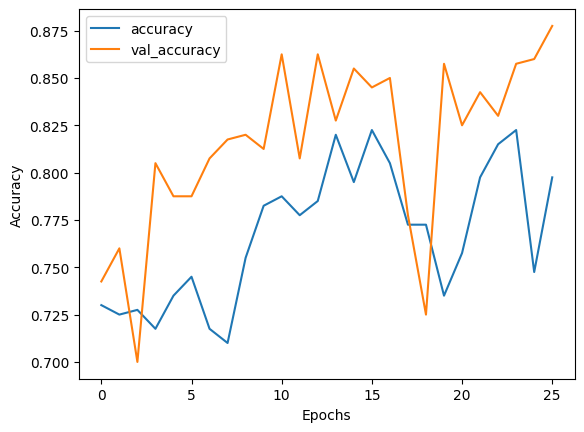

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(26), history.history['accuracy'])
plt.plot(np.arange(26), history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


# Predict image using the model

# Save the Trained Model

In [ ]:
from google.colab import files
saved_model_path = "./model_chili.h5"
model.save(saved_model_path)
files.download(saved_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp '/content/my_model_rice90.h5' '/content/drive/MyDrive/Colab/Model'

In [ ]:
!cp '/content/model_rice_new.json' '/content/drive/MyDrive/Colab/Model'

Save Model to Json

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files

# Load the saved model
saved_model_path = "./model_chili.h5"
model = load_model(saved_model_path)

# Convert the model to JSON format
json_model = model.to_json()

# Save the JSON model to a file
json_model_path = "./model_chili.json"
with open(json_model_path, "w") as json_file:
    json_file.write(json_model)

# Download the JSON model file
files.download(json_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Save to TensorFlow Lite

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files


saved_model_path = "./model_chili.h5"
model = load_model(saved_model_path)


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


tflite_model_path = "./model_chili.tflite"
with open(tflite_model_path, "wb") as tflite_file:
    tflite_file.write(tflite_model)

files.download(tflite_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert

In [ ]:
with open ("model.tflite","wb") as tflite_file:
     tflite_file.write(converter)

In [ ]:
import os
from PIL import Image

folder_path = '/content/dataset/DATASET/Val'

def check_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verifikasi gambar
            except (IOError, SyntaxError) as e:
                print("File rusak:", file_path)

check_images(folder_path)
